In [2]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
import wbgapi as wb
from functools import reduce
import dask.dataframe as dd
import locale
import geopandas as gpd

## Q1

For this question, we are going to use [Istanbul Municipality Data Service](https://data.ibb.gov.tr/). Specifically, we are going to look at the 'Saatlik Trafik Yoğunluk Veri Seti' dataset.

1. Write a function that takes a year and a month as parameters that pulls the data for that specific year and month and returns the data as a pandas dataframe.
2. Using this function get the data for September 2023.
3. Group the data with respect to GEOHASH column, and then aggragate
   - 'LONGITUDE' column using 'first'
   - 'LATITUDE' column using 'first'
   - 'AVERAGE_SPEED' using 'mean'
   - 'NUMBER_OF_VEHICLES' using 'mean'
4. Find the first 25 data points with
   - the highest average number of vehicles
   - the highest average speed
   - the lowest average speed
5. Create a heatmap using [folium](https://pypi.org/project/folium/) library on the 'NUMBER_OF_VEHICLES' column of the dataframe you constructed in Step 2.

## Q1-ANSWER
We will use  'Saatlik Trafik Yoğunluk Veri Seti' dataset from  Istanbul Municipality Data Service .

We should write a function that takes a year and a month as parameters that pulls the data for that specific year and month and returns the data as a pandas dataframe. Each month stored seperate datasets with resource_id. 'Saatlik Trafik Yoğunluk Veri Seti' is a package with resource informations(id,description,url etc.). From resources,there are two dict items that i interested: resource id and url. Here is an example of them:

'resource_id': 'f6a1e2d7-0d9f-4d84-90c6-2729a0869308'
'url': 'https://data.ibb.gov.tr/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/f6a1e2d7-0d9f-4d84-90c6-2729a0869308/download/traffic_density_202308.csv'

I defined a function called 'extract_last_part_from_url' to take the date part from the url and keep them with resouce id s in a dict so that i can  reach resource id's by using date information. Aafter that, by using resource id, i can pull the data from datasetsearch actions.

In [2]:
def extract_last_part_from_url(url):
    """ Takes url as a parameter and return date part.
      Parameters:
        url
      Returns:
        datepart: string date info with format %y%m(i.e. 202012 for 2020 December)
    """
    parts = url.split('/')
    last_part = parts[-1]
    date_part = last_part.split('_')[-1][:6] #first 6 digits because date is 6 digit(i.e. 202003.csv is last splitted element)
    return date_part

In [3]:
def find_dataset(month,year):
    """ Takes month and year as a parameter and pulls corresponding data.
      Parameters:
        month: string month with long format (i.e. 'September')
        year: string year (i.e. '2020')
      Returns:
        df: DataFrame of correspondng data
    """
    months = {
    "January": "01",
    "February": "02",
    "March": "03",
    "April": "04",
    "May": "05",
    "June": "06",
    "July": "07",
    "August": "08",
    "September": "09",
    "October": "10",
    "November": "11",
    "December": "12"
    }
    date = year + months[month] # same format with url

    url = 'https://data.ibb.gov.tr/api/3/action/package_search?q=hourly-traffic-density-data-set'
    response = requests.get(url)
    data=response.json()
    resource = data['result']['results'][0]['resources']
    names = {extract_last_part_from_url(i['url']):i['resource_id'] for i in resource} # dict with date:resource_id
    resource_id = names[date] #corresponding resource_id
    
    url2 = f'https://data.ibb.gov.tr/api/3/action/datastore_search?resource_id={resource_id}'# corresponding datastore
    response2 = requests.get(url2)
    data2 = response2.json()
    record = data2['result']['records'] # dataset
    df = pd.DataFrame(record)
    
    return df

Now, let's get the data for September 2023:

In [4]:
data_df = find_dataset('September','2023')
data_df.head()

,_id,DATE_TIME,LONGITUDE,LATITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,1,2023-09-01 00:00:00,29.3170166015625,40.9213256835938,sxkbg1,8,121,65,95
1,2,2023-09-01 00:00:00,29.1632080078125,40.9158325195313,sxk8z8,4,84,29,18
2,3,2023-09-01 00:00:00,29.1302490234375,41.1300659179688,sxk9yz,48,118,70,15
3,4,2023-09-01 00:00:00,29.0863037109375,41.0092163085938,sxk9mc,4,157,56,158
4,5,2023-09-01 00:00:00,28.8116455078125,40.9927368164063,sxk3pw,13,111,67,110


Now, we will group the data with respect to GEOHASH column and then do some aggregations:

In [5]:
grouped_geohash = data_df.groupby(['GEOHASH']).agg({'LONGITUDE':'first','LATITUDE':'first','AVERAGE_SPEED':'mean','NUMBER_OF_VEHICLES':'mean'})
grouped_geohash

,LONGITUDE,LATITUDE,AVERAGE_SPEED,NUMBER_OF_VEHICLES
GEOHASH,,,,
sx7chw,27.9766845703125,40.9927368164063,59.0,35.0
sx7cmh,27.9986572265625,41.0256958007813,67.0,30.0
sx7cv2,28.0096435546875,41.0916137695313,76.0,25.0
sx7cx7,28.0975341796875,41.0641479492188,79.0,36.0
sx7fvc,28.0316162109375,41.2728881835938,88.0,16.0
...,...,...,...,...
sxkd7c,28.9984130859375,41.1849975585938,43.0,4.0
sxkd81,28.8336181640625,41.2289428710938,89.0,178.0
sxkdk4,29.0093994140625,41.1904907226563,40.0,4.0


Now, we will find the first 25 data points with the highest average number of vehicles:

In [6]:
highest_avg_vehicles = grouped_geohash.sort_values(by='NUMBER_OF_VEHICLES',ascending=False).head(25)
highest_avg_vehicles

,LONGITUDE,LATITUDE,AVERAGE_SPEED,NUMBER_OF_VEHICLES
GEOHASH,,,,
sxk3k8,28.6798095703125,41.0037231445313,61.0,334.0
sxk9pp,29.1412353515625,40.9982299804688,76.0,303.0
sxk9c2,28.8885498046875,41.0916137695313,54.0,268.0
sxk9py,29.1741943359375,40.9927368164063,80.0,251.0
sxkc1d,29.2510986328125,40.9707641601563,59.0,223.0
sxk9u8,29.0313720703125,41.0916137695313,83.0,189.0
sxkd81,28.8336181640625,41.2289428710938,89.0,178.0
sxk9mc,29.0863037109375,41.0092163085938,56.0,158.0
sxkd30,28.8775634765625,41.1795043945313,88.0,150.0


The first 25 data points with the highest average speed:

In [7]:
highest_avg_speed = grouped_geohash.sort_values(by='AVERAGE_SPEED',ascending=False).head(25)
highest_avg_speed

,LONGITUDE,LATITUDE,AVERAGE_SPEED,NUMBER_OF_VEHICLES
GEOHASH,,,,
sxk4pg,28.4710693359375,41.1520385742188,102.0,24.0
sxk4nq,28.4051513671875,41.1685180664063,100.0,2.0
sxk9wb,29.1302490234375,41.0476684570313,99.0,47.0
sxk1cm,28.1854248046875,41.1190795898438,99.0,40.0
sxk40n,28.1304931640625,41.1685180664063,98.0,24.0
sxkbk3,29.3719482421875,40.8334350585938,93.0,131.0
sxk384,28.4820556640625,41.0586547851563,92.0,31.0
sxk1g7,28.2733154296875,41.1080932617188,92.0,58.0
sxk4hg,28.3392333984375,41.1520385742188,91.0,33.0


In [8]:
lowest_avg_speed = grouped_geohash.sort_values(by='AVERAGE_SPEED',ascending=True).head(25)
lowest_avg_speed

,LONGITUDE,LATITUDE,AVERAGE_SPEED,NUMBER_OF_VEHICLES
GEOHASH,,,,
sxk928,28.8555908203125,41.0037231445313,18.0,35.0
sxkbv6,29.4158935546875,40.9268188476563,19.0,2.0
sxk92f,28.8665771484375,41.0147094726563,20.0,48.0
sxk929,28.8555908203125,41.0092163085938,20.0,33.0
sxk9t1,29.0533447265625,41.0531616210938,22.0,10.0
sxk971,28.9654541015625,41.0092163085938,23.0,9.0
sxk9my,29.0863037109375,41.0366821289063,23.0,12.0
sxk9mz,29.0863037109375,41.0421752929688,23.0,15.0
sxk3j7,28.7127685546875,40.9762573242188,23.0,22.0


In [9]:

data_df['LATITUDE'] = pd.to_numeric(data_df['LATITUDE'])
data_df['LONGITUDE'] = pd.to_numeric(data_df['LONGITUDE'])
data_df['NUMBER_OF_VEHICLES'] = pd.to_numeric(data_df['NUMBER_OF_VEHICLES'])

m = folium.Map([data_df['LATITUDE'].iloc[1], data_df['LONGITUDE'].iloc[1]]) #generated the map, iloc is for more centered starting point
HeatMap(data_df[['LATITUDE', 'LONGITUDE','NUMBER_OF_VEHICLES']].values).add_to(m) # add coordinates and give # of vehiches as a weight to heatmap
m

## Q2

For this question, we are going to build a map. To build a map, we are going to merge several data sources.

- Get the shape files for Turkish administrative level 0 (iller) and level 1 (ilçeler) from [GADM](https://gadm.org) using their API.
- Get the census population data (both at level 0 and level 1) for the year 2000 from [TUIK](https://biruni.tuik.gov.tr) using their API.
- Get the crime statistics (suç türü ve suçun işlendiği ile göre infaz kurumuna giren hükümlüler) from [TUIK](https://biruni.tuik.gov.tr) using their API.

You need to poke around GADM and TUIK to find out which data you will need. For the GADM data, the API allows URL access. For TUIK data, you will have to download the data into a local file and load it. However, DO NOT clean data by hand. The raw data has to be loaded as a pandas frame and cleaning must be done programmatically for replication purposes. You will have to push the files you downloaded to github. Name the files as `HW2-Population-level0.xlsx`,  `HW2-Population-level1.xlsx` and `HW2-Crime.xlsx`.

After getting the data

1. Create a [GeoPandas][1] dataframe from the shape data, and merge it with population data (with level 1).
2. Using GeoPandas sketch a choropleth map for the population at administrative level 1 (ilçeler)
3. Merge shape data (level 0), the population data (level 0) and the cleaned crime data.
4. On the dataframe you created in Step 3, transform the totals for each crime type for each municipality into a percentage by dividing it by the correct population number.
5. Using the data you generated in Step 4, sketch two choropleth maps using GeoPandas for the two crime types of your choosing at administrative level 0 (iller)

[1]: https://geopandas.org/en/stable/

## Q2-ANSWER


For this question, first i define a function that cleans census population file for iller:

In [3]:
def clean_data4il(excel_file,name):
    cleaned = excel_file.dropna()
    cleaned = cleaned.T.head(2)
    cleaned.index = [name,'Toplam Nüfus']
    cleaned =cleaned.T
    cleaned.drop(cleaned.index[0],inplace=True)
    return cleaned



In [4]:
level0_pop = pd.read_excel(r'C:\Users\user\Desktop\OKUL\GUZ_23-24\MAT381-Introduction_to_datascience\MAT381-IntroductionToDataScience\HW2\HW2-Population-level0.xlsx')
locale.setlocale(locale.LC_ALL, 'tr_TR.UTF-8')
cleaned_level0 = clean_data4il(level0_pop,'Iller')
level0_reindexed = cleaned_level0.reset_index(drop=True)
level0_reindexed = level0_reindexed.sort_values(by='Iller',key=lambda x: x.map(locale.strxfrm))
level0_reindexed = level0_reindexed.reset_index(drop=True)
level0_reindexed 



,Iller,Toplam Nüfus
0,Adana,1849478
1,Adıyaman,623811
2,Afyon,812416
3,Ağrı,528744
4,Aksaray,396084
...,...,...
76,Uşak,322313
77,Van,877524
78,Yalova,168593
79,Yozgat,682919


In here, i cleaned census population for ilçeler:

In [5]:
level1_pop = pd.read_excel(r'C:\Users\user\Desktop\OKUL\GUZ_23-24\MAT381-Introduction_to_datascience\MAT381-IntroductionToDataScience\HW2\HW2-Population-level1.xlsx')
locale.setlocale(locale.LC_ALL, 'tr_TR.UTF-8')
level1_pop.drop(columns=['TÜRKİYE İSTATİSTİK KURUMU','Unnamed: 5','Unnamed: 6'], inplace=True)# drop unnecessary columns
level1_pop['Unnamed: 1'].fillna(method='ffill', inplace=True)
for index,row in level1_pop.iterrows():
    if not pd.isna(row['Unnamed: 3']):
        row['Unnamed: 2']=row['Unnamed: 3'] # carrying alt kademe to ilçe
level1_pop.drop(columns=['Unnamed: 3'],inplace=True) # drop alt kademe
level1_pop.dropna(axis=0, how='all',inplace=True) # drop empty rows
level1_pop.drop(level1_pop.index[[0,1]],inplace=True)# drop unnecessary texts('Alt kademe','Toplam')
level1_pop.columns = ['Iller','Ilceler','Toplam Nüfus'] #renaming
level1_reindexed = level1_pop.reset_index(drop=True)
level1_reindexed = level1_reindexed.sort_values(by='Iller',key=lambda x: x.map(locale.strxfrm))
level1_reindexed = level1_reindexed.reset_index(drop=True)
level1_reindexed


,Iller,Ilceler,Toplam Nüfus
0,Adana,Seyhan,807934
1,Adana,Yumurtalık,4745
2,Adana,Tufanbeyli,5332
3,Adana,Saimbeyli,5198
4,Adana,Pozantı,9627
...,...,...,...
941,Zonguldak,Alaplı,18487
942,Zonguldak,Çaycuma,18734
943,Zonguldak,Devrek,21360
944,Zonguldak,Ereğli,79486


Now, i take the shape files for iller ve ilçeler :

In [6]:
level0_shape = 'https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_TUR_1.json'
level1_shape = 'https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_TUR_2.json'
response1 = requests.get(level0_shape)
data_il = response1.json()
response2 = requests.get(level1_shape)
data_ilce = response2.json()


There were some wrong city names, so i created a dict:

In [7]:
correct_forms = {
    'Adana': 'Adana',
    'Adiyaman': 'Adıyaman',
    'Afyon': 'Afyonkarahisar',
    'Agri': 'Ağrı',
    'Aksaray': 'Aksaray',
    'Amasya': 'Amasya',
    'Ankara': 'Ankara',
    'Antalya': 'Antalya',
    'Ardahan': 'Ardahan',
    'Artvin': 'Artvin',
    'Aydin': 'Aydın',
    'Balikesir': 'Balıkesir',
    'Bartın': 'Bartın',
    'Batman': 'Batman',
    'Bayburt': 'Bayburt',
    'Bilecik': 'Bilecik',
    'Bingöl': 'Bingöl',
    'Bitlis': 'Bitlis',
    'Bolu': 'Bolu',
    'Burdur': 'Burdur',
    'Bursa': 'Bursa',
    'Çanakkale': 'Çanakkale',
    'Çankiri': 'Çankırı',
    'Çorum': 'Çorum',
    'Denizli': 'Denizli',
    'Diyarbakir': 'Diyarbakır',
    'Düzce': 'Düzce',
    'Edirne': 'Edirne',
    'Elazığ': 'Elazığ',
    'Erzincan': 'Erzincan',
    'Erzurum': 'Erzurum',
    'Eskisehir': 'Eskişehir',
    'Gaziantep': 'Gaziantep',
    'Giresun': 'Giresun',
    'Gümüshane': 'Gümüşhane',
    'Hakkari': 'Hakkari',
    'Hatay': 'Hatay',
    'Iğdır': 'Iğdır',
    'Isparta': 'Isparta',
    'Istanbul': 'İstanbul',
    'Izmir': 'İzmir',
    'K.Maras': 'Kahramanmaraş',
    'Karabük': 'Karabük',
    'Karaman': 'Karaman',
    'Kars': 'Kars',
    'Kastamonu': 'Kastamonu',
    'Kayseri': 'Kayseri',
    'Kilis': 'Kilis',
    'Kinkkale': 'Kırıkkale',
    'Kirklareli': 'Kırklareli',
    'Kirsehir': 'Kırşehir',
    'Kocaeli': 'Kocaeli',
    'Konya': 'Konya',
    'Kütahya': 'Kütahya',
    'Malatya': 'Malatya',
    'Manisa': 'Manisa',
    'Mardin': 'Mardin',
    'Mersin': 'Mersin',
    'Mugla': 'Muğla',
    'Mus': 'Muş',
    'Nevsehir': 'Nevşehir',
    'Nigde': 'Niğde',
    'Ordu': 'Ordu',
    'Osmaniye': 'Osmaniye',
    'Rize': 'Rize',
    'Sakarya': 'Sakarya',
    'Samsun': 'Samsun',
    'Sanliurfa': 'Şanlıurfa',
    'Siirt': 'Siirt',
    'Sinop': 'Sinop',
    'Sirnak': 'Şırnak',
    'Sivas': 'Sivas',
    'Tekirdag': 'Tekirdağ',
    'Tokat': 'Tokat',
    'Trabzon': 'Trabzon',
    'Tunceli': 'Tunceli',
    'Usak': 'Uşak',
    'Van': 'Van',
    'Yalova': 'Yalova',
    'Yozgat': 'Yozgat',
    'Zinguldak': 'Zonguldak'
}


Now, i fix the city names,and rename some columns for ilçeler gdp:

In [8]:
gdf_ilce = gpd.read_file(level1_shape)
gdf_ilce['NAME_1']= gdf_ilce['NAME_1'].replace(correct_forms)
gdf_ilce.rename(columns={'NAME_1':'Iller','NAME_2':'Ilceler'},inplace=True)

gdf_ilce

,GID_2,GID_0,COUNTRY,GID_1,Iller,NL_NAME_1,Ilceler,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,TUR.1.1_1,TUR,Turkey,TUR.1_1,Adana,NA,Aladağ,NA,NA,District,District,NA,TR.AA.AL,"MULTIPOLYGON (((35.58970 37.94590, 35.56940 37..."
1,TUR.1.2_1,TUR,Turkey,TUR.1_1,Adana,NA,Ceyhan,NA,NA,District,District,NA,TR.AA.CE,"MULTIPOLYGON (((35.93400 36.87990, 35.92240 36..."
2,TUR.1.3_1,TUR,Turkey,TUR.1_1,Adana,NA,Feke,NA,NA,District,District,NA,TR.AA.FE,"MULTIPOLYGON (((35.64170 37.70990, 35.62810 37..."
3,TUR.1.4_1,TUR,Turkey,TUR.1_1,Adana,NA,İmamoğlu,NA,NA,District,District,NA,TR.AA.IM,"MULTIPOLYGON (((35.43950 37.30670, 35.45380 37..."
4,TUR.1.5_1,TUR,Turkey,TUR.1_1,Adana,NA,Karaisali,NA,NA,District,District,NA,TR.AA.KS,"MULTIPOLYGON (((35.09230 37.49990, 35.12020 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,TUR.81.2_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Çaycuma,NA,NA,District,District,NA,TR.ZO.CA,"MULTIPOLYGON (((32.02100 41.56290, 32.03240 41..."
925,TUR.81.3_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Devrek,NA,NA,District,District,NA,TR.ZO.DE,"MULTIPOLYGON (((32.09200 41.01840, 31.91220 41..."
926,TUR.81.4_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Ereğli,NA,NA,District,District,NA,TR.ZO.ER,"MULTIPOLYGON (((31.73630 41.04270, 31.59990 41..."
927,TUR.81.5_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Gökçebey,NA,NA,District,District,NA,TR.ZO.GO,"MULTIPOLYGON (((32.24630 41.34900, 32.27430 41..."


Then, i merged ilçeler gdp and level1_reindexed on iller and ilçeler to make sure merging is correct:

In [9]:
merged_ilce_df = pd.merge(gdf_ilce, level1_reindexed, on=['Ilceler','Iller'], how='left')
merged_ilce_df


,GID_2,GID_0,COUNTRY,GID_1,Iller,NL_NAME_1,Ilceler,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,Toplam Nüfus
0,TUR.1.1_1,TUR,Turkey,TUR.1_1,Adana,NA,Aladağ,NA,NA,District,District,NA,TR.AA.AL,"MULTIPOLYGON (((35.58970 37.94590, 35.56940 37...",6674
1,TUR.1.2_1,TUR,Turkey,TUR.1_1,Adana,NA,Ceyhan,NA,NA,District,District,NA,TR.AA.CE,"MULTIPOLYGON (((35.93400 36.87990, 35.92240 36...",108602
2,TUR.1.3_1,TUR,Turkey,TUR.1_1,Adana,NA,Feke,NA,NA,District,District,NA,TR.AA.FE,"MULTIPOLYGON (((35.64170 37.70990, 35.62810 37...",4632
3,TUR.1.4_1,TUR,Turkey,TUR.1_1,Adana,NA,İmamoğlu,NA,NA,District,District,NA,TR.AA.IM,"MULTIPOLYGON (((35.43950 37.30670, 35.45380 37...",30428
4,TUR.1.5_1,TUR,Turkey,TUR.1_1,Adana,NA,Karaisali,NA,NA,District,District,NA,TR.AA.KS,"MULTIPOLYGON (((35.09230 37.49990, 35.12020 37...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,TUR.81.2_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Çaycuma,NA,NA,District,District,NA,TR.ZO.CA,"MULTIPOLYGON (((32.02100 41.56290, 32.03240 41...",18734
925,TUR.81.3_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Devrek,NA,NA,District,District,NA,TR.ZO.DE,"MULTIPOLYGON (((32.09200 41.01840, 31.91220 41...",21360
926,TUR.81.4_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Ereğli,NA,NA,District,District,NA,TR.ZO.ER,"MULTIPOLYGON (((31.73630 41.04270, 31.59990 41...",79486
927,TUR.81.5_1,TUR,Turkey,TUR.81_1,Zonguldak,NA,Gökçebey,NA,NA,District,District,NA,TR.ZO.GO,"MULTIPOLYGON (((32.24630 41.34900, 32.27430 41...",7939


Now, we will sketch a choropleth map for the population at ilçeler :

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\user\AppData\Local\Temp\ipykernel_9568\1959658287.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged_ilce_df.geometry.centroid.x, merged_ilce_df.geometry.centroid.y, merged_ilce_df['Toplam Nüfus']):


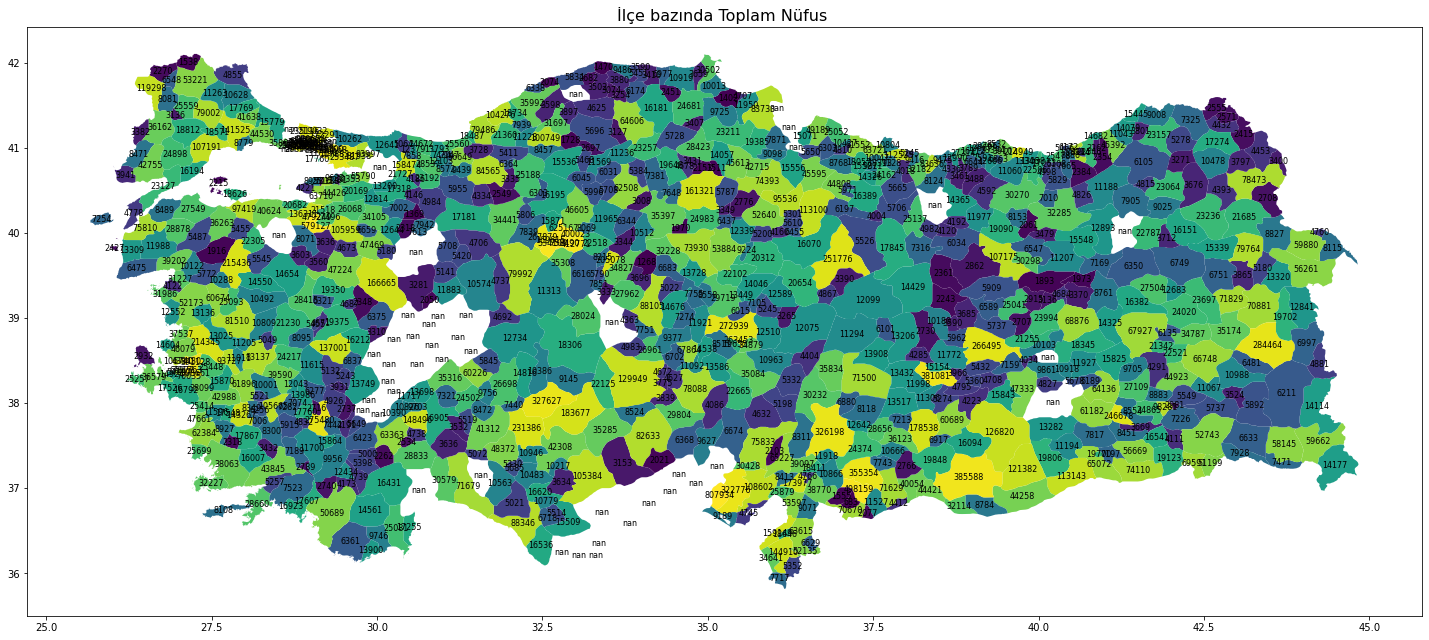

In [60]:
bx = merged_ilce_df.plot(column='Toplam Nüfus', figsize=(25, 15), cmap='viridis')
for x, y, label in zip(merged_ilce_df.geometry.centroid.x, merged_ilce_df.geometry.centroid.y, merged_ilce_df['Toplam Nüfus']):
    bx.text(x, y, label, fontsize=8, ha='center', va='center')
plt.title(f"İlçe bazında {'Toplam Nüfus'} ", fontsize=16)
plt.show()

For this part of the question, i will clean the crime data, and merge crime-population-ilçeler shape file : 

In [23]:
crime_data = pd.read_excel(r'C:\Users\user\Desktop\OKUL\GUZ_23-24\MAT381-Introduction_to_datascience\MAT381-IntroductionToDataScience\HW2\HW2-Crime.xlsx')
crime_data.dropna(axis=0, how='all',inplace=True) #drop empty rows
crime_data.drop(columns=['Unnamed: 0'],inplace=True) #drop empty column
crime_data['Unnamed: 1'].fillna(method='ffill', inplace=True)# fill suç türü for each row

new_columns = crime_data.iloc[0,:].tolist() #first row contains iller, we will take them as a col name
crime_data.columns = new_columns # make first row column name
crime_data = crime_data[1:] # remove first row

new_colnames =['Suç türü','Yıl']+list(level0_reindexed['Iller']) #rename column names
crime_data.columns = new_colnames
numeric_columns = crime_data.columns[2:] #take numeric data
crime_data[numeric_columns] = crime_data[numeric_columns].apply(pd.to_numeric, errors='coerce') #convert to numeric 
crime_total = crime_data.groupby('Suç türü').sum() # i could not decide whether to use sum or mean,there are approximately 15 years of data, but we have population data for only year 2000.

a = crime_total.T[1:] # take iller to columns,throw Yıl row
a_n = a.reset_index() 
a_n.rename(columns={'index':'Iller'},inplace=True) #take İller to another column from index column
merged_df = pd.merge(a_n, level0_reindexed, on='Iller') # merge population and crime data based on Iller
merged_df


,Iller,Suç türü:1. (Öldürme),Suç türü:10. (Mala Zarar Verme),Suç türü:2. (Yaralama),Suç türü:3. (Cinsel Suçlar),Suç türü:4. (Tehdit),Suç türü:5. (Kişiyi Hürriyetinden Yoksun Kılma),Suç türü:7. (Hakaret),Suç türü:8. (Hırsızlık),Suç türü:9. (Yağma (Gasp)),Toplam Nüfus
0,Adana,3504.0,677.0,9727.0,1371.0,2494.0,889.0,1155.0,16340.0,3539.0,1849478
1,Adıyaman,372.0,78.0,1099.0,145.0,263.0,69.0,102.0,1679.0,210.0,623811
2,Afyon,1283.0,223.0,3606.0,679.0,1116.0,538.0,445.0,3350.0,805.0,812416
3,Ağrı,463.0,86.0,1652.0,261.0,534.0,213.0,199.0,1852.0,428.0,528744
4,Aksaray,410.0,137.0,1614.0,250.0,515.0,179.0,253.0,1313.0,128.0,396084
...,...,...,...,...,...,...,...,...,...,...,...
76,Uşak,787.0,155.0,2444.0,547.0,867.0,223.0,350.0,2483.0,575.0,322313
77,Van,13039.0,2461.0,34973.0,6450.0,5966.0,3606.0,3612.0,77969.0,24746.0,877524
78,Yalova,5739.0,1739.0,20751.0,3383.0,5335.0,1755.0,3471.0,34368.0,9403.0,168593
79,Yozgat,1364.0,232.0,3238.0,373.0,608.0,318.0,253.0,5736.0,894.0,682919


Then, i calculated percentage crime rates :

In [24]:
percentage_crime = merged_df.copy()
for i in range(1, merged_df.shape[1]-1): # only suç türü columns
    percentage_crime[merged_df.columns[i]] = ((merged_df[merged_df.columns[i]] / merged_df['Toplam Nüfus']) * 100) # percentage
percentage_crime


,Iller,Suç türü:1. (Öldürme),Suç türü:10. (Mala Zarar Verme),Suç türü:2. (Yaralama),Suç türü:3. (Cinsel Suçlar),Suç türü:4. (Tehdit),Suç türü:5. (Kişiyi Hürriyetinden Yoksun Kılma),Suç türü:7. (Hakaret),Suç türü:8. (Hırsızlık),Suç türü:9. (Yağma (Gasp)),Toplam Nüfus
0,Adana,0.189459,0.036605,0.525932,0.074129,0.134849,0.048068,0.06245,0.883493,0.191351,1849478
1,Adıyaman,0.059633,0.012504,0.176175,0.023244,0.04216,0.011061,0.016351,0.269152,0.033664,623811
2,Afyon,0.157924,0.027449,0.443861,0.083578,0.137368,0.066222,0.054775,0.41235,0.099087,812416
3,Ağrı,0.087566,0.016265,0.312439,0.049362,0.100994,0.040284,0.037636,0.350264,0.080947,528744
4,Aksaray,0.103513,0.034589,0.407489,0.063118,0.130023,0.045192,0.063875,0.331495,0.032316,396084
...,...,...,...,...,...,...,...,...,...,...,...
76,Uşak,0.244173,0.04809,0.758269,0.169711,0.268993,0.069187,0.10859,0.770369,0.178398,322313
77,Van,1.485885,0.280448,3.985418,0.735023,0.679867,0.410929,0.411613,8.885113,2.81998,877524
78,Yalova,3.404056,1.031478,12.30834,2.006608,3.164426,1.040968,2.058804,20.385188,5.577337,168593
79,Yozgat,0.199731,0.033972,0.474141,0.054618,0.08903,0.046565,0.037047,0.839924,0.130909,682919


After that, i define a function for sketching choropleth map for crime rates :

In [25]:
def sketch_choropleth (il_shape,perc_crime_df,col_name): # i had to take shape file, when i take merged df, i couldnt plot the polygons, just datapoints
    gdf2 = gpd.read_file(il_shape)
    gdf2['VARNAME_1']=perc_crime_df['Iller']
    gdf2.rename(columns={'VARNAME_1':'Iller'},inplace=True)
    gdf2 = gdf2[['Iller', 'geometry']]
    df = pd.merge(gdf2,perc_crime_df,on='Iller')

    df[col_name] = pd.to_numeric(df[col_name],errors ='coerce')
    df[col_name] = df[col_name].round(2)

    ax = df.plot(column=col_name, figsize=(20, 10), legend=True, cmap='viridis')
    for x, y, label in zip(df.geometry.centroid.x, df.geometry.centroid.y, df[col_name]):
        ax.text(x, y, label, fontsize=8, ha='center', va='center')
    plt.title(f"İl bazında {col_name} oranı (%)", fontsize=16)
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_9568\2902869530.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(df.geometry.centroid.x, df.geometry.centroid.y, df[col_name]):


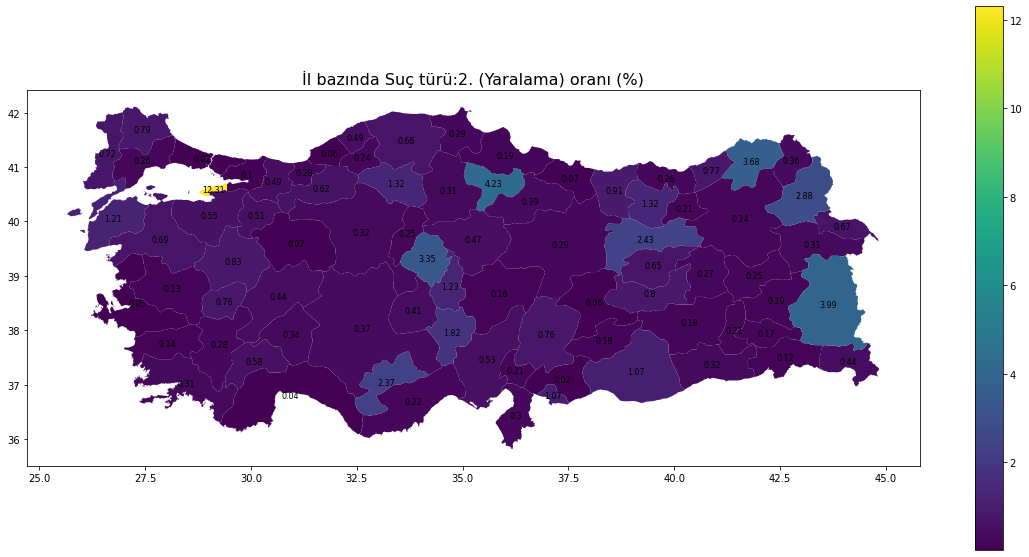

In [26]:
sketch_choropleth(level0_shape,percentage_crime,'Suç türü:2. (Yaralama)')

C:\Users\user\AppData\Local\Temp\ipykernel_9568\2902869530.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(df.geometry.centroid.x, df.geometry.centroid.y, df[col_name]):


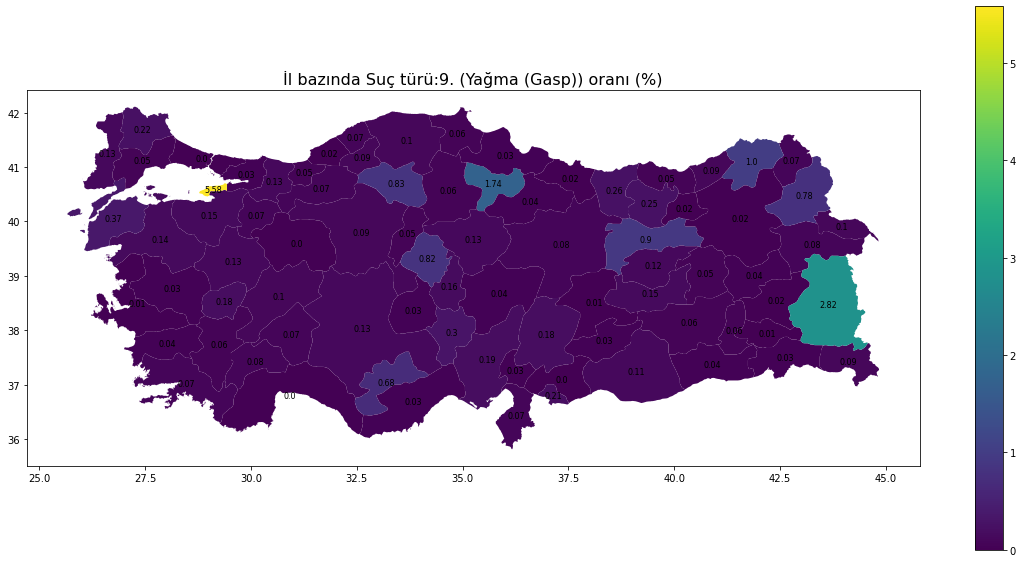

In [27]:
sketch_choropleth(level0_shape,percentage_crime,'Suç türü:9. (Yağma (Gasp))')

## Q3

For this question, you are going to use [WorldBank Data API](https://data.worldbank.org/) through the python library [wbgapi](https://pypi.org/project/wbgapi/). 

1. Get the following data for the following countries: Albania, Bosnia and Herzegovina, Bulgaria, Croatia, Kosovo, Montenegro, North Macedonia, Romania, Serbia, Slovenia, Turkey, Greece, Cyprus, Malta, Italy, Poland, Belarus, and Ukraine.

* Child mortality under 5 year olds
* Female literacy rate for ages 15+
* Female labor force participation rate for ages 15+) 
* Poverty headcount ratio at $3.65 a day as a percentage of the population
* GDP Per capita
* CPIA gender equality rating

2. Merge the data you obtained into a single data frame such that you have the following columns. Pivot the data frames whenever necessary:

- Year
- Country
- Child Mortality
- Female Literacy
- Female Workforce Participation
- Poverty
- GDP
- Gender Equality

3. Write a function that takes the following as parameters

- The data frame
- The name of the country
- The column name

that plots the time series (in years, in the correct order) of the corresponding column for the corresponding country. Sketch 4 such graphs of your choosing, both in terms of country and column.

4. Write a function that takes the following as parameters

- The data frame
- Years as a list 
- A pair of column names

that sketches a scatter plot of the pair of columns for every country for the list of particular years. Sketch 4 such graphs of your choosing from 2010 to 2020.

5. Sketch 'Child Mortality' against 'Female Literacy' for all countries and for all available years as a scatter plot. Analyze the graph and draw conclusions.

6. Sketch 'Female Workforce Participation' against 'Child Mortality' for all countries and for all available years as a scatter plot. Analyze the graph and draw conclusions.
   
7. Make a violin plot of 'Female Literacy' column against 'Gender Equality' column for all countries and for all available years. Investigate any correlation between these variables.


## Q3-ANSWER
For this question, we will get the following data for related  countries: 
* Child mortality under 5 year olds
* Female literacy rate for ages 15+
* Female labor force participation rate for ages 15+
* Poverty headcount ratio at $3.65 a day as a percentage of the population
* GDP Per capita
* CPIA gender equality rating

First of all, i realized that in World Bank Data, countries contains with ISO 3166-1 alpha-3 country codes. So, i create a list of countiry codes of related countries:

In [28]:
country_codes = ['ALB', 'BIH', 'BGR', 'HRV', 'XKX', 'MNE', 'MKD', 'ROU', 'SRB', 'SVN', 'TUR', 'GRC', 'CYP', 'MLT', 'ITA', 'POL', 'BLR', 'UKR']

Then, by searching the databases and packages, i found id s of related series of related data, and keep them as a dictionary to understand which id belongs to which data:

In [29]:
codes ={'gdp_per_capital':'NY.GDP.PCAP.CD','female_literacy':'SE.ADT.LITR.FE.ZS','female_labor':'SL.TLF.CACT.FE.NE.ZS','cpia':'IQ.CPA.GNDR.XQ','child_mort':'SH.DYN.MORT','poverty':'SI.POV.LMIC'}

Now, i can pull the related data through wbgapi. Again, i put all datas into a dict in order to distinguish them and also i convert data to Dataframe in order to manipulate easily:

In [30]:
dataframes = {key: wb.data.DataFrame(value,country_codes) for key, value in codes.items()}

Let's have a look one of the dataframes:

In [31]:
dataframes['female_labor']

,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,YR1969,...,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022
economy,,,,,,,,,,,,,,,,,,,,,
ALB,36.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.94,43.98,47.04,49.73,49.57,51.32,52.87,NaN,NaN,NaN
BGR,NaN,NaN,NaN,NaN,NaN,59.47,NaN,NaN,NaN,NaN,...,48.56,48.62,48.56,47.66,49.52,49.22,50.29,49.20,49.05,50.57
BIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.32,32.94,33.42,32.06,32.28,31.37,32.78,36.71,40.64,41.11
BLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,85.50,66.91,67.13,66.22,66.34,65.68,65.77,65.79
CYP,40.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.22,58.72,57.80,56.43,56.88,57.46,57.53,56.71,57.89,59.62
GRC,NaN,35.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.36,43.76,44.33,44.44,44.21,43.78,43.85,43.35,43.53,44.67
HRV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.59,46.43,46.88,45.43,45.57,45.51,45.18,44.68,45.79,46.85
ITA,NaN,24.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.68,40.12,39.77,40.45,40.93,41.10,41.26,39.84,40.11,40.69
MKD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.18,43.77,43.37,42.41,42.70,42.38,44.62,43.70,42.88,42.22


I need a single dataframe consisting of following columns:
* Year
* Country
* Child Mortality
* Female Literacy
* Female Workforce Participation
* Poverty
* GDP
* Gender Equality

Thus, for each dataframe,i need to take country names, years and column values as a single column. So, i write a function 'melt_and_merge_dask' in order to implement this steps into all dataframes:

In [32]:
def melt_and_merge_dask(dfs):
    """ Takes a dict of dataframes where key is name of data and value is dataframe, convert x and y axes to multiple index columns and put values to a one column.
      Parameters:
        dfs: Dictionary(key:name of DataFrame,value:DataFrame)
 
      Returns:
        df2: single dataframe consisting each dataframes info in one column.
    """
    df_lists = []
    
    for key, value in dfs.items():
        df = pd.melt(value.reset_index(), id_vars=value.index.names, var_name='Year', value_name=key)
        df_lists.append(df)
    
    # Convert to dask dataframes(until here, i wrote the function, but after taking error, i add reamining part from ChatGpt)
    ddf_lists = [dd.from_pandas(df, npartitions=1) for df in df_lists]
    
    # Merge dask dataframes
    combined_ddf = dd.concat(ddf_lists, axis=1, interleave_partitions=True)
    
    # Compute the result
    combined_df = combined_ddf.compute()
    
    df2 = combined_df.T.drop_duplicates().T
    df2.rename(columns={'economy': 'Countries'}, inplace=True)
    return df2

result_df = melt_and_merge_dask(dataframes)
result_df


,Countries,Year,gdp_per_capital,female_literacy,female_labor,cpia,child_mort,poverty
0,ALB,YR1960,NaN,NaN,36.35,NaN,NaN,NaN
1,BGR,YR1960,NaN,NaN,NaN,NaN,55.4,NaN
2,BIH,YR1960,NaN,NaN,NaN,NaN,NaN,NaN
3,BLR,YR1960,NaN,NaN,NaN,NaN,NaN,NaN
4,CYP,YR1960,NaN,NaN,40.82,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1129,SRB,YR2022,9393.628906,NaN,50.97,NaN,NaN,NaN
1130,SVN,YR2022,29457.402844,NaN,54.25,NaN,NaN,NaN
1131,TUR,YR2022,10616.061045,NaN,35.11,NaN,NaN,NaN
1132,UKR,YR2022,4533.975586,NaN,NaN,NaN,NaN,NaN


Although df llooks fine, we can convert Year column into datetime in order to create accurate time series:

In [33]:
result_df['Year'] = result_df['Year'].str[2:]
result_df['Year'] = pd.to_datetime(result_df['Year']).dt.year
result_df

,Countries,Year,gdp_per_capital,female_literacy,female_labor,cpia,child_mort,poverty
0,ALB,1960,NaN,NaN,36.35,NaN,NaN,NaN
1,BGR,1960,NaN,NaN,NaN,NaN,55.4,NaN
2,BIH,1960,NaN,NaN,NaN,NaN,NaN,NaN
3,BLR,1960,NaN,NaN,NaN,NaN,NaN,NaN
4,CYP,1960,NaN,NaN,40.82,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1129,SRB,2022,9393.628906,NaN,50.97,NaN,NaN,NaN
1130,SVN,2022,29457.402844,NaN,54.25,NaN,NaN,NaN
1131,TUR,2022,10616.061045,NaN,35.11,NaN,NaN,NaN
1132,UKR,2022,4533.975586,NaN,NaN,NaN,NaN,NaN


Now, we will write a function that takes the following as parameters:
* The data frame
* The name of the country
* The column name

that plots the time series (in years, in the correct order) of the corresponding column for the corresponding country.

In [34]:
def plot_time_series(df,country,col_name):
    """ Takes DataFrame, country name and column name as a parameter and sketch the time series of the corresponding column for the corresponding country.
      Parameters:
        dfs: DataFrame
        country: Country name
        col_name: Corresponding column name

    """
    new_df = df[df['Countries'] == country].loc[:,['Year',col_name]]
    new_df = new_df.sort_values(by='Year')
    new_df.plot(x='Year',y=col_name)



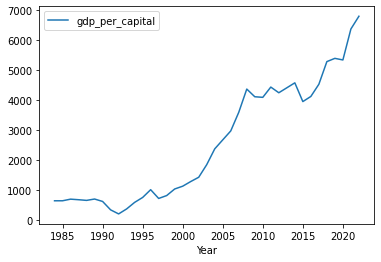

In [35]:
plot_time_series(result_df,'ALB','gdp_per_capital')

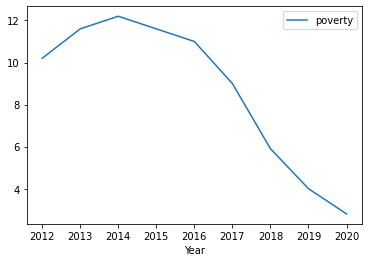

In [36]:
plot_time_series(result_df,'SRB','poverty')

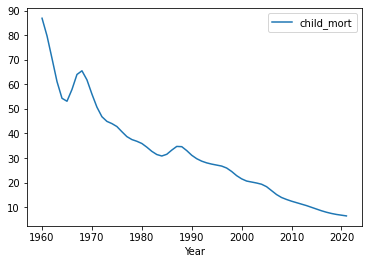

In [37]:
plot_time_series(result_df,'ROU','child_mort')
    

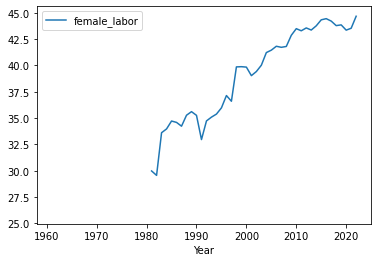

In [38]:
plot_time_series(result_df,'GRC','female_labor')

Now, we will write a function that takes the following as parameters
* The data frame
* Years as a list
* A pair of column names

that sketches a scatter plot of the pair of columns for every country for the list of particular years.

In [39]:
def sketch_scatter(df,years,columns):
    """ Takes DataFrame, list of years and  two columns in a list, sketch scatter plot of values for related column by country.
      Parameters:
        df: DataFrame
        years: years as a list
        columns: 2 column names as a list

    """
    for country, data in df[df['Year'].isin(years)].groupby('Countries'):
        plt.scatter(data[columns[0]], data[columns[1]], label=country)
    plt.title(f'Scatter Plot: {columns[0]} vs {columns[1]}')
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    plt.legend(loc='upper right')

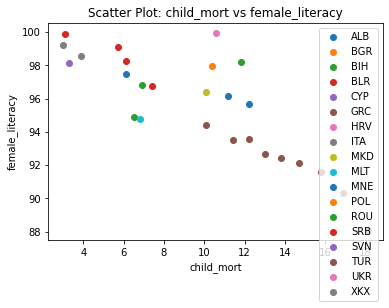

In [40]:
sketch_scatter(result_df,list(range(2010,2020)),['child_mort','female_literacy'])

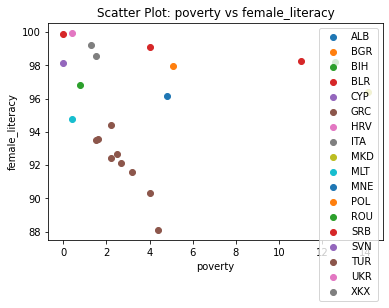

In [41]:
sketch_scatter(result_df,list(range(2010,2020)),['poverty','female_literacy'])

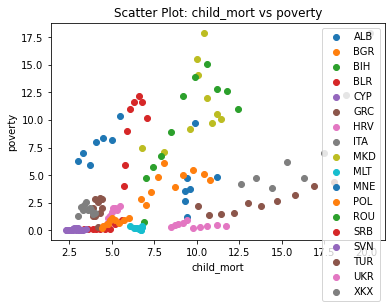

In [42]:
sketch_scatter(result_df,list(range(2010,2020)),['child_mort','poverty'])

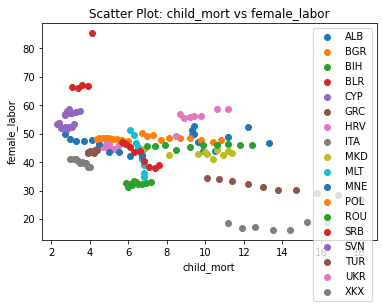

In [43]:
sketch_scatter(result_df,list(range(2010,2020)),['child_mort','female_labor'])

Now we will sketch two columns for all countries and years. We can define a function:

In [44]:
def sketch_4all(df,columns):
    for country, data in df.groupby('Countries'):
        plt.scatter(data[columns[0]], data[columns[1]], label=country)
    plt.title(f'Scatter Plot: {columns[0]} vs {columns[1]}')
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    plt.legend(loc='upper right')
    plt.xlim(0, 40)
    

We will Sketch 'Child Mortality' against 'Female Literacy' for all countries and for all available years as a scatter plot:

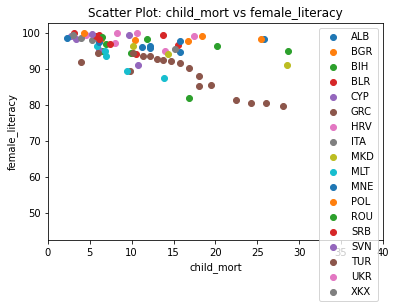

In [45]:
sketch_4all(result_df,['child_mort','female_literacy'])

As we can see, 'Child Mortality' and 'Female Literacy' are inversely proportional.

Now, lets sketch 'Female Workforce Participation' against 'Child Mortality' for all countries and for all available years as a scatter plot:

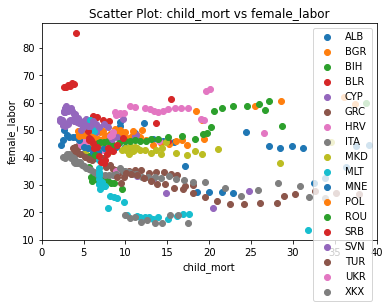

In [46]:
sketch_4all(result_df,['child_mort','female_labor'])

As we can see, for most of the countries, again 'Female Workforce Participation' and 'Child Mortality' inversely proportional.

Now, we will make a violin plot of 'Female Literacy' column against 'Gender Equality' column for all countries and for all available years.To make it easier, lets defne a function:

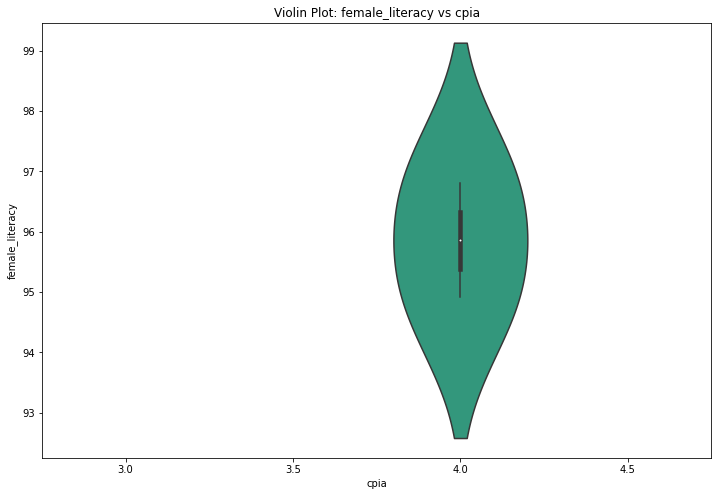

In [47]:
def violin_plot(df, x_column_name, y_column_name):
    # Convert the specified columns to numeric
    x_column = pd.to_numeric(df[x_column_name], errors='coerce')
    y_column = pd.to_numeric(df[y_column_name], errors='coerce')

    # Drop NaN values
    x_column = x_column.dropna()
    y_column = y_column.dropna()

    # Create the violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(x=x_column, y=y_column, palette='viridis')
    plt.title(f'Violin Plot: {y_column_name} vs {x_column_name}')
    plt.xlabel(x_column_name)
    plt.ylabel(y_column_name)
    plt.show()

# Example usage:
violin_plot(result_df, 'cpia', 'female_literacy')


As we can above, upper adjacent value and lower adjacent value are too far away from outside points. Thus we can not claim any correlation between 'Female Literacy' and 'Gender Equality', we should not forget how many data do we have:

In [48]:
result_df[['cpia', 'female_literacy']].shape

(1134, 2)

In [49]:
result_df[['cpia', 'female_literacy']].isnull().sum()

cpia               1107
female_literacy    1055
dtype: int64

Unfortunately, we do not have enough data to investigate any correlation accurately.